<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/notebooks/%E8%B3%83%E9%87%91%E6%A7%8B%E9%80%A0%E5%9F%BA%E6%9C%AC%E8%AA%BF%E6%9F%BBexcel%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From 神エクセル ETL
- e-statのAPI(DB)は反映が一年程度遅延している
- また賃金構造基本調査の2009年以前の補正データは今のところAPIは公開していない
- 以下では、e-statのサイトから直接excelファイルを取得して加工するプロセスを紹介する

## 事前準備
- まず、excelファイルのファイルURL(パラメータ)を探す必要がある
- 残念ながら、規則性は認められず、人力で探すしかない
- 以下は2020年と2021年のファイルパスである
- 以下の様にクロームの「右クリック -> 検証」でファイルのパラメータを確認できる（もしくは、一度ダウンロードして、そのネットワークパラメータを探しても良い）



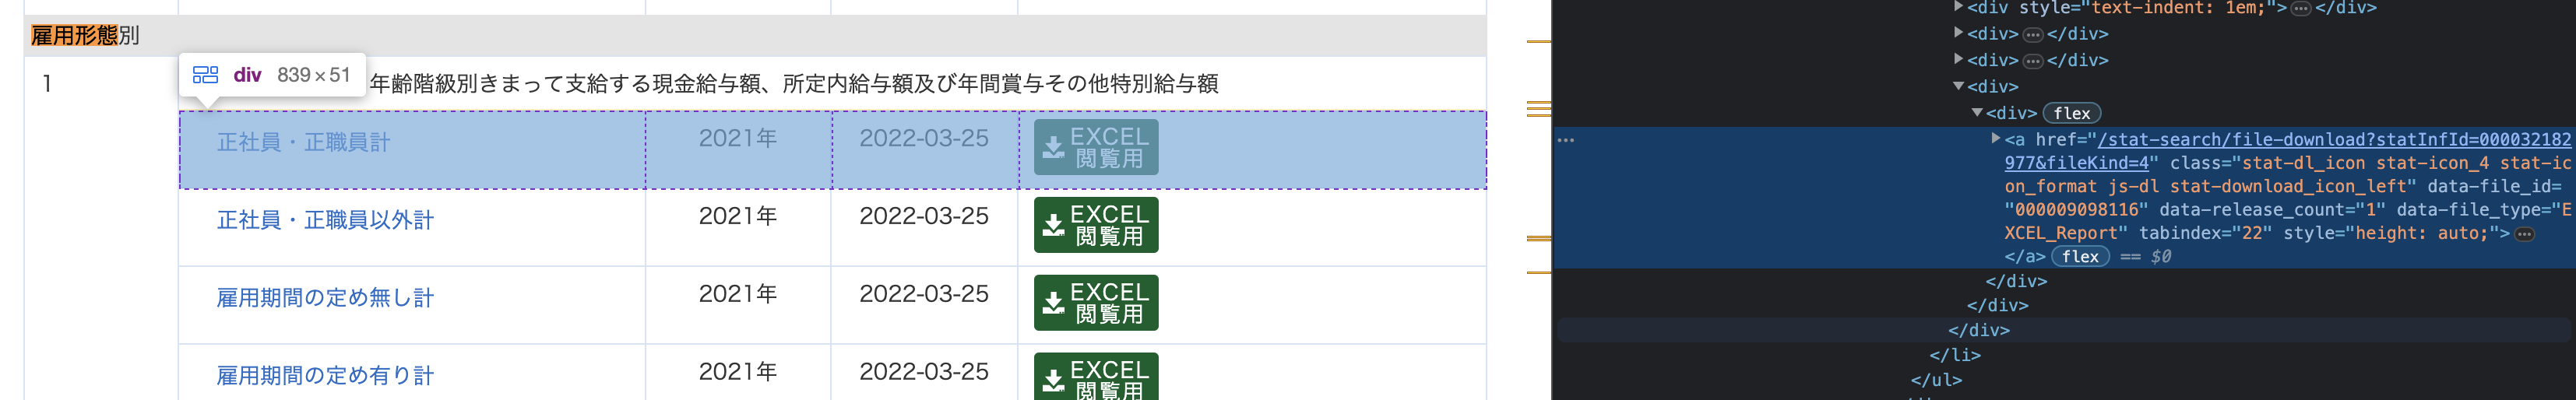

In [1]:
_URL = "https://www.e-stat.go.jp/"

after_path_dict = {
    "2020" : {
        "正社員・正職員計" : "/stat-search/file-download?statInfId=000032069456&fileKind=0",
        "正社員・正職員以外計" : "/stat-search/file-download?statInfId=000032069457&fileKind=0" 
    },
    "2021" : {
        "正社員・正職員計" : "/stat-search/file-download?statInfId=000032182977&fileKind=4",
        "正社員・正職員以外計" : "/stat-search/file-download?statInfId=000032182978&fileKind=4" 
    }
}

## 2019年以前のファイルパス（パラメータ）を探索
- 以下の作業は初見では難しく感じるかもしれない。難しければ、根性で上記通り探せばよい
- 探索すべきパスが多いため、半自動で探したい

### やってること : 2019年以前のファイルも同様にファイルパスを探す
- 当該サイトは動的サイトであるためseleniumを使う
- e-statの「賃金構造基本調査」検索の２ページ目に対象ファイルがあることを確認している
    - **[注意] つまり、このページが今後ずれるかもしれない**。もっと良い検索ページ募集中
- 当該検索ページの２ページ目にseleniumでアクセスし、
- "（令和２年と同じ推計方法による集計）雇用形態、年齢階級別きまって支給する現金給与額、所定内給与額及び年間賞与その他特別給与額"というテーブルで、かつ、正社員 or 正社員以外のファイルパスを取得して、保存する

In [2]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install -q selenium

Executing: /tmp/apt-key-gpghome.PzvLIidgd2/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.oW3xJSOz2T/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.qz0yJRacJm/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

In [3]:
import datetime
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

In [4]:
#@title ブラウザをheadlessモード実行
options = Options()
options.add_argument("--headless") # or use pyvirtualdiplay
options.add_argument("--no-sandbox") # needed, because colab runs as root
# options.add_argument('--disable-dev-shm-usage') 

options.headless = True

driver = webdriver.Chrome("chromedriver", options=options)

<ipython-input-4-795666fc83f2>:7: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True


In [5]:
page = 2
serch_url = f"https://www.e-stat.go.jp/stat-search/files?page={page}&layout=datalist&toukei=00450091&tstat=000001011429&metadata=1&data=1"
driver.get(serch_url)
time.sleep(3)
print(driver.title)

賃金構造基本統計調査 | ファイル | 統計データを探す | 政府統計の総合窓口


In [6]:
before_path_dict = {}

elems = driver.find_elements(By.CLASS_NAME, "stat-dataset_list-detail-item")
for elem in elems:
    if elem.text.find("（令和２年と同じ推計方法による集計）雇用形態、年齢階級別きまって支給する現金給与額、所定内給与額及び年間賞与その他特別給与額") >= 0:
        _temp = elem.text.split("\n")
        if _temp[1] in ["正社員・正職員計", "正社員・正職員以外計"]:
            _yyyy = re.sub(r"\D", "", _temp[2])
            _path = BeautifulSoup(elem.get_attribute('outerHTML'), 'html.parser').find_all(href=re.compile("/stat-search/file-download"))[0].attrs['href']
            before_path_dict[_yyyy + "_" + _temp[1]] = _path


In [7]:
driver.quit()

In [8]:
#@title 中身の確認
before_path_dict

{'2009_正社員・正職員計': '/stat-search/file-download?statInfId=000032135133&fileKind=4',
 '2008_正社員・正職員計': '/stat-search/file-download?statInfId=000032135195&fileKind=4',
 '2007_正社員・正職員計': '/stat-search/file-download?statInfId=000032135257&fileKind=4',
 '2006_正社員・正職員計': '/stat-search/file-download?statInfId=000032135319&fileKind=4',
 '2019_正社員・正職員計': '/stat-search/file-download?statInfId=000032117087&fileKind=4',
 '2018_正社員・正職員計': '/stat-search/file-download?statInfId=000032117103&fileKind=4',
 '2017_正社員・正職員計': '/stat-search/file-download?statInfId=000032117119&fileKind=4',
 '2016_正社員・正職員計': '/stat-search/file-download?statInfId=000032117135&fileKind=4',
 '2015_正社員・正職員計': '/stat-search/file-download?statInfId=000032117151&fileKind=4',
 '2014_正社員・正職員計': '/stat-search/file-download?statInfId=000032117167&fileKind=4',
 '2013_正社員・正職員計': '/stat-search/file-download?statInfId=000032117183&fileKind=4',
 '2012_正社員・正職員計': '/stat-search/file-download?statInfId=000032117199&fileKind=4',
 '2011_正社員・正職員計'

## 神エクセルを整形する
- 今回は*”所定内給与額”*に着目するが、他の項目でもやり方は同じなので各自でチャレンジ
- また、2019年以前と2020年以降でexcel構造が違っているようなので、分けて処理する

In [9]:
# @title 2020年以降の所定内給与額
after2020_df = []

for _yyyy in after_path_dict.keys():
    for _job_type in after_path_dict[_yyyy].keys():
        print(f"{_yyyy}年 {_job_type} 取得中 :", _URL + after_path_dict[_yyyy][_job_type])
        input_file = pd.ExcelFile(_URL + after_path_dict[_yyyy][_job_type])
        industry_names = input_file.sheet_names
        for _industry in industry_names:
            _df = input_file.parse(
                _industry,
                skiprows=11,
                usecols="C, I, Q, Y, AG",  # "C:AI"
                names=[
                    "temp_category",
                    "企業規模計（10人以上）",
                    "1,000人以上",
                    "100～999人",
                    "10～99人",
                ],
            )
            assert (
                _df.tail(1)["temp_category"].values[0] == "７０歳～"
            ), "assertion error : 最後の行が不正です。確認してください"

            _df = _df.assign(
                gender=_df["temp_category"]
                .apply(
                    lambda x: str(x).split("\n")[0] if str(x).find("\n") > 0 else np.nan
                )
                .fillna(method="ffill"),
                education=_df["temp_category"]
                .apply(
                    lambda x: str(x).split("\n")[1] if str(x).find("\n") > 0 else (str(x) if str(x).find("歳") < 0 else np.nan)
                )
                .fillna(method="ffill"),
                age=np.where(
                    _df["temp_category"].str.contains("歳"), _df["temp_category"], "年齢計"
                ),
            ).drop(columns="temp_category")

            _df = pd.melt(
                _df,
                id_vars=["age", "education", "gender"],
                value_name="value",
                var_name="corporate_scale",
                col_level=None,
            )

            _df = _df.assign(
                year=_yyyy,
                industry=_industry,
                unit="所定内給与額",
                job_type=_job_type,
                original_url=_URL + after_path_dict[_yyyy][_job_type],
            )

            after2020_df.append(_df)


after2020_df = pd.concat(after2020_df).reset_index(drop=True)

2020年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032069456&fileKind=0
2020年 正社員・正職員以外計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032069457&fileKind=0
2021年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032182977&fileKind=4
2021年 正社員・正職員以外計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032182978&fileKind=4


In [10]:
after2020_df

,age,education,gender,corporate_scale,value,year,industry,unit,job_type,original_url
0,年齢計,学歴計,男女計,企業規模計（10人以上）,324.2,2020,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
1,～１９歳,学歴計,男女計,企業規模計（10人以上）,180.2,2020,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
2,２０～２４歳,学歴計,男女計,企業規模計（10人以上）,215.4,2020,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
3,２５～２９歳,学歴計,男女計,企業規模計（10人以上）,249.6,2020,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
4,３０～３４歳,学歴計,男女計,企業規模計（10人以上）,282.8,2020,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
...,...,...,...,...,...,...,...,...,...,...
84859,５０～５４歳,不明,女,10～99人,181.4,2021,Ｒサービス業（他に分類されないもの）,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...
84860,５５～５９歳,不明,女,10～99人,184.4,2021,Ｒサービス業（他に分類されないもの）,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...
84861,６０～６４歳,不明,女,10～99人,164.5,2021,Ｒサービス業（他に分類されないもの）,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...
84862,６５～６９歳,不明,女,10～99人,154.7,2021,Ｒサービス業（他に分類されないもの）,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...


In [11]:
# @title 2019年以前の所定内給与額
before2020_df = []

for yyyy_job_type in before_path_dict.keys():
    _yyyy, _job_type = yyyy_job_type.split("_")

    print(f"{_yyyy}年 {_job_type} 取得中 :", _URL + before_path_dict[yyyy_job_type])
    input_file = pd.ExcelFile(_URL + before_path_dict[yyyy_job_type])
    industry_names = input_file.sheet_names
    for _industry in industry_names:
        _df = input_file.parse(
            _industry,
            skiprows=11,
            usecols="C, I, Q, Y, AG",  # "C:AI"
            names=[
                "temp_category",
                "企業規模計（10人以上）",
                "1,000人以上",
                "100～999人",
                "10～99人",
            ],
        )
        assert (
            _df.tail(1)["temp_category"].values[0] == "７０歳～"
        ), "assertion error : 最後の行が不正です。確認してください"

        _df = _df.assign(
                gender = _df["temp_category"].apply(lambda x: str(x).replace("　", "").strip().split("\n")[0] if str(x).find("\n")> 0 else np.nan).fillna(method='ffill'),
                education = _df["temp_category"].apply(lambda x: "学歴計" if str(x).find("\n")> 0 else (str(x).replace("　", "").strip() if str(x).find("歳") < 0 else np.nan)).fillna(method='ffill'),
                age = np.where(_df["temp_category"].str.contains("歳"), _df["temp_category"], '年齢計'),
            ).drop(columns='temp_category')

        _df = pd.melt(
                _df, 
                id_vars=["age", "education", "gender"], 
                value_name='value', 
                var_name="corporate_scale",
           )

        _df = _df.assign(
            year=_yyyy,
            industry=_industry,
            unit="所定内給与額",
            job_type=_job_type,
            original_url=_URL + before_path_dict[yyyy_job_type],
        )

        before2020_df.append(_df)


before2020_df = pd.concat(before2020_df).reset_index(drop=True)

2009年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032135133&fileKind=4
2008年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032135195&fileKind=4
2007年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032135257&fileKind=4
2006年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032135319&fileKind=4
2019年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117087&fileKind=4
2018年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117103&fileKind=4
2017年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117119&fileKind=4
2016年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117135&fileKind=4
2015年 正社員・正職員計 取得中 : https://www.e-stat.go.jp//stat-search/file-download?statInfId=000032117151&fileKind=4
2014年 正社員・正職員計 取得中 : https://www.e-st

In [12]:
before2020_df

,age,education,gender,corporate_scale,value,year,industry,unit,job_type,original_url
0,年齢計,学歴計,男 女 計,企業規模計（10人以上）,310.1,2009,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
1,～１９歳,学歴計,男 女 計,企業規模計（10人以上）,168.3,2009,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
2,２０～２４歳,学歴計,男 女 計,企業規模計（10人以上）,199.6,2009,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
3,２５～２９歳,学歴計,男 女 計,企業規模計（10人以上）,235.1,2009,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
4,３０～３４歳,学歴計,男 女 計,企業規模計（10人以上）,273.4,2009,産業計,所定内給与額,正社員・正職員計,https://www.e-stat.go.jp//stat-search/file-dow...
...,...,...,...,...,...,...,...,...,...,...
361915,５０～５４歳,大学・大学院卒,女,10～99人,213.5,2010,Ｒサービス業(他に分類されないもの),所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...
361916,５５～５９歳,大学・大学院卒,女,10～99人,187.6,2010,Ｒサービス業(他に分類されないもの),所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...
361917,６０～６４歳,大学・大学院卒,女,10～99人,216.5,2010,Ｒサービス業(他に分類されないもの),所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...
361918,６５～６９歳,大学・大学院卒,女,10～99人,129.2,2010,Ｒサービス業(他に分類されないもの),所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...


### 2019年以前とそれ以降で各カラムの表記を（できるだけ）揃える
- 学歴は以前は大学と大学院を一緒にしているので分離不能
- 産業区分は途中で微妙に定義が変わっているので注意
- 年齢は単純にrename

In [13]:
def print_unique_elements(_df: pd.DataFrame) -> dict:
    """
    [input]
        _df : [pandas.DataFrame] 加工したテーブル
    [output]
        None
    """
    cols = [col for col in _df.columns if col not in  ["value", "original_url"]]
    for _col in cols:
        print(f"{_col} : ", _df[_col].unique())

In [14]:
print_unique_elements(after2020_df)

age :  ['年齢計' '\u3000\u3000～１９歳' '２０～２４歳' '２５～２９歳' '３０～３４歳' '３５～３９歳' '４０～４４歳'
 '４５～４９歳' '５０～５４歳' '５５～５９歳' '６０～６４歳' '６５～６９歳' '７０歳～']
education :  ['学歴計' '中学' '高校' '専門学校' '高専・短大' '大学' '大学院' '不明']
gender :  ['男女計' '男' '女']
corporate_scale :  ['企業規模計（10人以上）' '1,000人以上' '100～999人' '10～99人']
year :  ['2020' '2021']
industry :  ['産業計' 'Ｃ鉱業，採石業，砂利採取業' 'Ｄ建設業' 'Ｅ製造業' 'Ｆ電気・ガス・熱供給・水道業' 'Ｇ情報通信業' 'Ｈ運輸業，郵便業'
 'Ｉ卸売業，小売業' 'Ｊ金融業，保険業' 'Ｋ不動産業，物品賃貸業' 'Ｌ学術研究，専門・技術サービス業' 'Ｍ宿泊業，飲食サービス業'
 'Ｎ生活関連サービス業，娯楽業' 'Ｏ教育，学習支援業' 'Ｐ医療，福祉' 'Ｑ複合サービス事業' 'Ｒサービス業（他に分類されないもの）']
unit :  ['所定内給与額']
job_type :  ['正社員・正職員計' '正社員・正職員以外計']


In [15]:
print_unique_elements(before2020_df)

age :  ['年齢計' '\u3000\u3000～１９歳' '２０～２４歳' '２５～２９歳' '３０～３４歳' '３５～３９歳' '４０～４４歳'
 '４５～４９歳' '５０～５４歳' '５５～５９歳' '６０～６４歳' '６５～６９歳' '７０歳～']
education :  ['学歴計' '中   学   卒' '高   校   卒' '高専・短大卒' '大学・大学院卒']
gender :  ['男 女 計' '男' '女']
corporate_scale :  ['企業規模計（10人以上）' '1,000人以上' '100～999人' '10～99人']
year :  ['2009' '2008' '2007' '2006' '2019' '2018' '2017' '2016' '2015' '2014'
 '2013' '2012' '2011' '2010']
industry :  ['産業計' 'Ｃ鉱業，採石業，砂利採取業' 'Ｄ建設業' 'Ｅ製造業' 'Ｆ電気・ガス・熱供給・水道業' 'Ｇ情報通信業' 'Ｈ運輸業，郵便業'
 'Ｉ卸売業，小売業' 'Ｊ金融業，保険業' 'Ｋ不動産業，物品賃貸業' 'Ｌ学術研究，専門・技術サービス業' 'Ｍ宿泊業，飲食サービス業'
 'Ｎ生活関連サービス業，娯楽業' 'Ｏ教育，学習支援業' 'Ｐ医療，福祉' 'Ｑ複合サービス事業' 'Ｒサービス業(他に分類されないもの)'
 'Ｄ鉱業' 'Ｅ建設業' 'Ｆ製造業' 'Ｇ電気・ガス・熱供給・水道業' 'Ｈ情報通信業' 'Ｉ運輸業' 'Ｊ卸売・小売業' 'Ｋ金融・保険業'
 'Ｌ不動産業' 'Ｍ飲食店，宿泊業' 'Ｎ医療，福祉' 'Ｐ複合サービス事業' 'Ｑサービス業（他に分類されないもの）']
unit :  ['所定内給与額']
job_type :  ['正社員・正職員計' '正社員・正職員以外計']


In [16]:
print(f"2019年以前の産業分類 : {len(before2020_df['industry'].unique())},  2020年以降の産業分類 : {len(after2020_df['industry'].unique())}")
print("")
print(before2020_df['industry'].unique())

2019年以前の産業分類 : 30,  2020年以降の産業分類 : 17

['産業計' 'Ｃ鉱業，採石業，砂利採取業' 'Ｄ建設業' 'Ｅ製造業' 'Ｆ電気・ガス・熱供給・水道業' 'Ｇ情報通信業' 'Ｈ運輸業，郵便業'
 'Ｉ卸売業，小売業' 'Ｊ金融業，保険業' 'Ｋ不動産業，物品賃貸業' 'Ｌ学術研究，専門・技術サービス業' 'Ｍ宿泊業，飲食サービス業'
 'Ｎ生活関連サービス業，娯楽業' 'Ｏ教育，学習支援業' 'Ｐ医療，福祉' 'Ｑ複合サービス事業' 'Ｒサービス業(他に分類されないもの)'
 'Ｄ鉱業' 'Ｅ建設業' 'Ｆ製造業' 'Ｇ電気・ガス・熱供給・水道業' 'Ｈ情報通信業' 'Ｉ運輸業' 'Ｊ卸売・小売業' 'Ｋ金融・保険業'
 'Ｌ不動産業' 'Ｍ飲食店，宿泊業' 'Ｎ医療，福祉' 'Ｐ複合サービス事業' 'Ｑサービス業（他に分類されないもの）']


In [17]:
print(after2020_df['industry'].unique())

['産業計' 'Ｃ鉱業，採石業，砂利採取業' 'Ｄ建設業' 'Ｅ製造業' 'Ｆ電気・ガス・熱供給・水道業' 'Ｇ情報通信業' 'Ｈ運輸業，郵便業'
 'Ｉ卸売業，小売業' 'Ｊ金融業，保険業' 'Ｋ不動産業，物品賃貸業' 'Ｌ学術研究，専門・技術サービス業' 'Ｍ宿泊業，飲食サービス業'
 'Ｎ生活関連サービス業，娯楽業' 'Ｏ教育，学習支援業' 'Ｐ医療，福祉' 'Ｑ複合サービス事業' 'Ｒサービス業（他に分類されないもの）']


##### 産業コードは注意
- 途中で名称が変わっている。共通で使えるように、最初の頭文字のみ使用する。定義が途中で変わる点に注意するべき

In [18]:
age_map = {
    "\u3000\u3000～１９歳": "age_00_19_group",
    "２０～２４歳": "age_20_24_group",
    "２５～２９歳": "age_25_29_group",
    "３０～３４歳": "age_30_34_group",
    "３５～３９歳": "age_35_39_group",
    "４０～４４歳": "age_40_44_group",
    "４５～４９歳": "age_45_49_group",
    "５０～５４歳": "age_50_54_group",
    "５５～５９歳": "age_55_59_group",
    "６０～６４歳": "age_60_64_group",
    "６５～６９歳": "age_65_69_group",
    "７０歳～": "age_70over_group",
}

In [19]:
after2020_df = after2020_df.assign(
    industry_code=after2020_df['industry'].apply(lambda x : x[:1] if str(x).find( "産業計") < 0 else x),
    age=after2020_df["age"].replace(
        age_map
    ),
    value=after2020_df["value"].replace("-",np.nan)
)

In [20]:
before2020_df = before2020_df.assign(
    industry_code=before2020_df['industry'].apply(lambda x : x[:1] if str(x).find( "産業計") < 0 else x),
    education=before2020_df["education"].replace(
        {
            "中   学   卒": "中学",
            "高   校   卒": "高校",
            "高専・短大卒": "高専・短大",
            "大学・大学院卒": "大学・大学院",
        }
    ),
    gender=before2020_df["gender"].replace(
        {
            "男 女 計": "男女計",
        }
    ),
    age=before2020_df["age"].replace(
        age_map
    ),
    value=before2020_df["value"].replace("-",np.nan)
)

In [21]:
print_unique_elements(after2020_df)

age :  ['年齢計' 'age_00_19_group' 'age_20_24_group' 'age_25_29_group'
 'age_30_34_group' 'age_35_39_group' 'age_40_44_group' 'age_45_49_group'
 'age_50_54_group' 'age_55_59_group' 'age_60_64_group' 'age_65_69_group'
 'age_70over_group']
education :  ['学歴計' '中学' '高校' '専門学校' '高専・短大' '大学' '大学院' '不明']
gender :  ['男女計' '男' '女']
corporate_scale :  ['企業規模計（10人以上）' '1,000人以上' '100～999人' '10～99人']
year :  ['2020' '2021']
industry :  ['産業計' 'Ｃ鉱業，採石業，砂利採取業' 'Ｄ建設業' 'Ｅ製造業' 'Ｆ電気・ガス・熱供給・水道業' 'Ｇ情報通信業' 'Ｈ運輸業，郵便業'
 'Ｉ卸売業，小売業' 'Ｊ金融業，保険業' 'Ｋ不動産業，物品賃貸業' 'Ｌ学術研究，専門・技術サービス業' 'Ｍ宿泊業，飲食サービス業'
 'Ｎ生活関連サービス業，娯楽業' 'Ｏ教育，学習支援業' 'Ｐ医療，福祉' 'Ｑ複合サービス事業' 'Ｒサービス業（他に分類されないもの）']
unit :  ['所定内給与額']
job_type :  ['正社員・正職員計' '正社員・正職員以外計']
industry_code :  ['産業計' 'Ｃ' 'Ｄ' 'Ｅ' 'Ｆ' 'Ｇ' 'Ｈ' 'Ｉ' 'Ｊ' 'Ｋ' 'Ｌ' 'Ｍ' 'Ｎ' 'Ｏ' 'Ｐ' 'Ｑ' 'Ｒ']


In [22]:
print_unique_elements(before2020_df)

age :  ['年齢計' 'age_00_19_group' 'age_20_24_group' 'age_25_29_group'
 'age_30_34_group' 'age_35_39_group' 'age_40_44_group' 'age_45_49_group'
 'age_50_54_group' 'age_55_59_group' 'age_60_64_group' 'age_65_69_group'
 'age_70over_group']
education :  ['学歴計' '中学' '高校' '高専・短大' '大学・大学院']
gender :  ['男女計' '男' '女']
corporate_scale :  ['企業規模計（10人以上）' '1,000人以上' '100～999人' '10～99人']
year :  ['2009' '2008' '2007' '2006' '2019' '2018' '2017' '2016' '2015' '2014'
 '2013' '2012' '2011' '2010']
industry :  ['産業計' 'Ｃ鉱業，採石業，砂利採取業' 'Ｄ建設業' 'Ｅ製造業' 'Ｆ電気・ガス・熱供給・水道業' 'Ｇ情報通信業' 'Ｈ運輸業，郵便業'
 'Ｉ卸売業，小売業' 'Ｊ金融業，保険業' 'Ｋ不動産業，物品賃貸業' 'Ｌ学術研究，専門・技術サービス業' 'Ｍ宿泊業，飲食サービス業'
 'Ｎ生活関連サービス業，娯楽業' 'Ｏ教育，学習支援業' 'Ｐ医療，福祉' 'Ｑ複合サービス事業' 'Ｒサービス業(他に分類されないもの)'
 'Ｄ鉱業' 'Ｅ建設業' 'Ｆ製造業' 'Ｇ電気・ガス・熱供給・水道業' 'Ｈ情報通信業' 'Ｉ運輸業' 'Ｊ卸売・小売業' 'Ｋ金融・保険業'
 'Ｌ不動産業' 'Ｍ飲食店，宿泊業' 'Ｎ医療，福祉' 'Ｐ複合サービス事業' 'Ｑサービス業（他に分類されないもの）']
unit :  ['所定内給与額']
job_type :  ['正社員・正職員計' '正社員・正職員以外計']
industry_code :  ['産業計' 'Ｃ' 'Ｄ' 'Ｅ' 'Ｆ' 'Ｇ' 'Ｈ' 'Ｉ' 'Ｊ' 'Ｋ' 'Ｌ' 'Ｍ' 'Ｎ' 'Ｏ' 'Ｐ' 'Ｑ' 'Ｒ']


In [23]:
#@title 統合データフレームの作成
merged_df = pd.concat([before2020_df, after2020_df]).reset_index(drop=True)
merged_df["year"] = merged_df["year"].astype(int)
merged_df.sample(5)

,age,education,gender,corporate_scale,value,year,industry,unit,job_type,original_url,industry_code
219378,age_25_29_group,学歴計,男女計,"1,000人以上",179.5,2006,Ｅ建設業,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｅ
254347,age_20_24_group,学歴計,男,企業規模計（10人以上）,204.1,2018,Ｑ複合サービス事業,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｑ
332637,age_40_44_group,高校,女,"1,000人以上",148.2,2012,Ｏ教育，学習支援業,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｏ
184800,age_35_39_group,学歴計,女,10～99人,127.6,2009,Ｆ電気・ガス・熱供給・水道業,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｆ
306014,age_45_49_group,大学・大学院,男女計,"1,000人以上",313.2,2014,Ｏ教育，学習支援業,所定内給与額,正社員・正職員以外計,https://www.e-stat.go.jp//stat-search/file-dow...,Ｏ


In [26]:
#@title この段階でcsvをローカルに保存したければ下記の様に実行
from google.colab import files

t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
_now = datetime.datetime.now(JST).strftime('%Y%m%d%H%M%S')

merged_df.to_csv(f'wage_structure_survey_{_now}.csv', index=False)
files.download(f'wage_structure_survey_{_now}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## サンプル分析

In [27]:
#@markdown ---
#@markdown ## 分析したい軸を選択してください
#@markdown ### チェックしなかったカラムは自動的に[総計]扱いにして集計した`model_df`を生成します
#@markdown ### インデックスはyearとする
age_checkbox = False #@param {type:"boolean"}
gender_checkbox = False #@param {type:"boolean"}
education_checkbox = False #@param {type:"boolean"}
corporate_scale_checkbox = True #@param {type:"boolean"}
industry_code_checkbox = False #@param {type:"boolean"}
#@markdown ---

query_str = "unit == '所定内給与額' and "
view_cols = ["year", "value", "job_type"]

if age_checkbox:
    query_str +=  "age != '年齢計' and "
    view_cols.append("age")
else:
    query_str +=  "age == '年齢計' and "

if gender_checkbox:
    query_str +=  "gender != '男女計' and "
    view_cols.append("gender")
else:
    query_str +=  "gender == '男女計' and "

if education_checkbox :
    query_str +=  "education != '学歴計' and "
    view_cols.append("education")
else:
    query_str +=  "education == '学歴計' and "

if corporate_scale_checkbox :
    query_str +=  "corporate_scale != '企業規模計（10人以上）' and "
    view_cols.append("corporate_scale")
else:
    query_str +=  "corporate_scale == '企業規模計（10人以上）' and "

if industry_code_checkbox :
    query_str +=  "industry_code != '産業計'"
    view_cols.append("industry_code")
else:
    query_str +=  "industry_code == '産業計'"

model_df = merged_df.query(query_str)[view_cols]


# fig = px.line(model_df, x="year", y="value", color="job_type")
# fig.show()
pivot_df = model_df.pivot_table(index='year', columns = view_cols[2:])

pivot_df

value                                         
job_type        正社員・正職員以外計                 正社員・正職員計                
corporate_scale   1,000人以上 100～999人 10～99人 1,000人以上 100～999人 10～99人
year                                                               
2006                 200.2    186.9  186.3    378.9    309.4  275.1
2007                 202.1    188.7  187.1    377.3    305.7  278.2
2008                 204.1    195.8  185.3    368.3    310.4  278.8
2009                 203.2    194.3  185.2    362.9    305.4  271.8
2010                 217.5    194.8  185.8    365.3    303.6  271.9
2011                 207.4    196.8  184.9    369.1    304.0  270.3
2012                 203.0    194.9  190.2    373.0    308.0  270.2
2013                 202.9    192.5  191.9    370.9    301.7  273.7
2014                 212.6    194.0  194.3    374.4    304.5  275.6
2015                 213.1    201.5  198.8    376.0    309.7  276.3
2016                 222.1    210.1  196.6    374.4    310.5  278.4
2017                 218.6    206.6  201.6    373.0    308.2  280.6
2018                 218.0    206.3  196.3    372.7    311.8  280.5
2019                 213.1    209.2  202.9    368.6    314.1  285.2
2020                 220.9    213.7  204.4    365.4    318.2  287.1
2021                 224.1    215.7  203.7    366.4    314.8  289.0

In [28]:
!pip install -q japanize-matplotlib

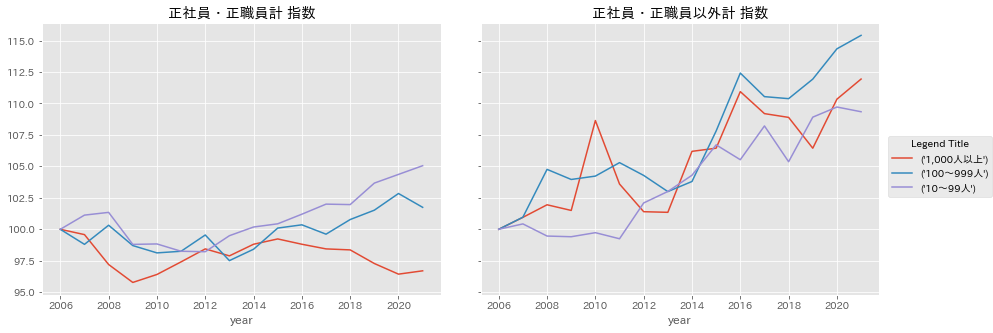

In [30]:
# @markdown ### 指数で表示したい場合は以下をチェックしてから再実行
index_value_checkbox = True  # @param {type:"boolean"}

import matplotlib.pyplot as plt
import japanize_matplotlib

japanize_matplotlib.japanize()
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
fulltime_cols = [col for col in pivot_df.columns if col[1] == "正社員・正職員計"]
parttime_cols = [col for col in pivot_df.columns if col[1] != "正社員・正職員計"]

plot_label = [
    str(_label).replace("'value', '正社員・正職員計', ", "") for _label in fulltime_cols
]

plt.subplots_adjust(wspace=0.1, hspace=0.6)

if index_value_checkbox:
    (100 * (1 + (pivot_df[fulltime_cols]).pct_change()).cumprod().fillna(1)).plot(
        ax=axes[0], legend=False
    )
    (100 * (1 + (pivot_df[parttime_cols]).pct_change()).cumprod().fillna(1)).plot(
        ax=axes[1], legend=False
    )
    axes[0].set_title("正社員・正職員計 指数")
    axes[1].set_title("正社員・正職員以外計 指数")
else:
    pivot_df[fulltime_cols].plot(ax=axes[0], legend=False)
    pivot_df[parttime_cols].plot(ax=axes[1], legend=False)
    axes[0].set_title("正社員・正職員計 実数")
    axes[1].set_title("正社員・正職員以外計 実数")

fig.legend(
    labels=plot_label, loc="center right", borderaxespad=0.1, title="Legend Title"
)
plt.show()

In [29]:
print("Done")

Done
